# Test case comparison

In [1]:
import numpy as np
from jax import jit, vjp, vmap, pmap, random, value_and_grad, nn
import jax
from jax import numpy as jnp
import equinox as eqx
import optax
from matplotlib import pyplot as plt


from jwave.geometry import Domain, Medium
from jwave.utils import display_complex_field

key = random.PRNGKey(42)  # Random seed


from hybridoed.forward import create_src_field, generate_2D_gridded_src_rec_positions
from hybridoed.oed import *


from jwave.geometry import Domain, Medium
from jwave.utils import display_complex_field

key = random.PRNGKey(42)  # Random seed


from hybridoed.forward import create_src_field
from hybridoed.oed import *

from functools import partial

from jax.example_libraries import optimizers
from tqdm import tqdm

from jwave import FourierSeries
from jwave.acoustics import simulate_wave_propagation
from jwave.geometry import (
    Domain,
    Medium,
    Sensors,
    Sources,
    TimeAxis,
    circ_mask,
    points_on_circle,
)
from jwave.signal_processing import apply_ramp, gaussian_window, smooth

## Loading models and defining sources/receivers

(500, 1, 70, 70)


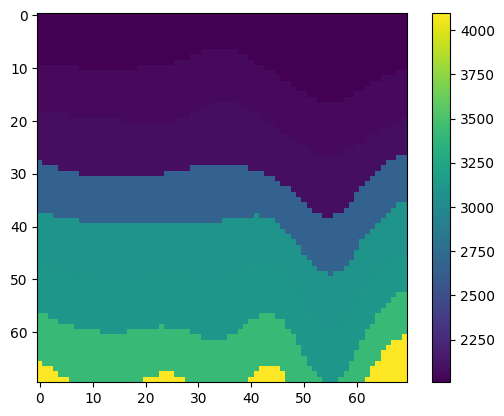

<class 'jaxlib.xla_extension.ArrayImpl'>


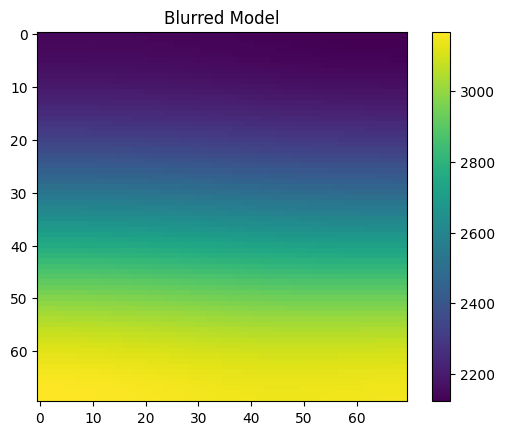

(70, 70)


In [2]:
# Load model

model = jnp.load('model1.npy')


print(model.shape)

model_index = 7

true_model = model[model_index,0,:,:]
plt.imshow(true_model)
plt.colorbar()
plt.show()
print(type(true_model))

from scipy.ndimage import gaussian_filter

# Apply a Gaussian blur
# Adjust sigma as needed; larger sigma = more blur
blurred_model = gaussian_filter(true_model, sigma=20)

# Visualize the blurred model
plt.figure()
plt.imshow(blurred_model, cmap='viridis')
plt.colorbar()
plt.title('Blurred Model')
plt.show()
print(blurred_model.shape)

# homogenous model of the velocity avegare

homogenous_model = jnp.ones(true_model.shape) * jnp.mean(true_model)

# plt.imshow(homogenous_model)


In [3]:
N = (70, 70)  # Grid size
dx = (1.0, 1.0)  # Spatial resolution
cfl=0.75

# Defining the domain
domain = Domain(N, dx)

source_freq = 200
source_mag = 1.3e-1
# source_mag = 1.3

medium = Medium(domain=domain, sound_speed=true_model, density=1000., pml_size=10)

# Time axis
time_axis = TimeAxis.from_medium(medium, cfl=cfl)
t = time_axis.to_array()
source_mag = source_mag / time_axis.dt

s1 = source_mag * jnp.sin(2 * jnp.pi * source_freq * t + 100)
signal = gaussian_window(apply_ramp(s1, time_axis.dt, source_freq), t, 0.5e-2, 1e-2)

# generate a ricker signal instead of a sinusoidal signal

def ricker_wavelet(t, f, t_shift=0.0):
    """
    Generate a Ricker wavelet with a time shift.

    Parameters:
        t (array-like): Time axis (e.g., jax.numpy array).
        f (float): Central frequency of the wavelet.
        t_shift (float): Time shift for the wavelet (default is 0.0).

    Returns:
        jax.numpy.ndarray: Ricker wavelet values at the given time points.
    """
    t_shifted = t - t_shift  # Apply the time shift
    pi2 = (jnp.pi ** 2)
    a = (pi2 * f ** 2) * (t_shifted ** 2)
    wavelet = (1 - 2 * a) * jnp.exp(-a)
    return wavelet


# Parameters
# source_freq = 25.0  # Central frequency in Hz
# t = jnp.linspace(-0.1, 0.2, 1000)  # Time vector in seconds
t_shift = 0.005  # Time shift in seconds

# Generate the Ricker wavelet with time shift
signal = source_mag * ricker_wavelet(t, source_freq, t_shift)

In [95]:
# def generate_2D_gridded_src_rec_positions(N=(70, 70), num_sources=20, num_receivers=10):
#     """
#     Generate a 2D grid of positions for sources and receivers with more sources than receivers,
#     arranged in a staggered grid. The offset between a source and a receiver is half the source spacing.

#     Parameters:
#     - N: Tuple[int, int], dimensions of the 2D grid (Nx, Ny).
#     - num_sources: int, number of source positions along each axis.
#     - num_receivers: int, number of receiver positions along each axis.

#     Returns:
#     - src_coords: jnp.ndarray, source positions as a 2D array.
#     - recv_coords: jnp.ndarray, receiver positions as a 2D array.
#     """
#     Nx, Ny = N

#     # Generate evenly spaced indices for sources
#     src_x = jnp.linspace(5, Nx - 5, num_sources, dtype=jnp.float32)
#     src_y = jnp.linspace(5, Ny - 5, num_sources, dtype=jnp.float32)

#     # Compute receiver positions with fewer points
#     recv_x = jnp.linspace(5 + (src_x[1] - src_x[0]) / 2, Nx - 5 - (src_x[1] - src_x[0]) / 2, num_receivers, dtype=jnp.float32)
#     recv_y = jnp.linspace(5 + (src_y[1] - src_y[0]) / 2, Ny - 5 - (src_y[1] - src_y[0]) / 2, num_receivers, dtype=jnp.float32)

#     # Create 2D grid coordinates for sources and receivers
#     src_coords = jnp.array([[x, y] for x in src_x for y in src_y], dtype=jnp.int32)
#     recv_coords = jnp.array([[x, y] for x in recv_x for y in recv_y], dtype=jnp.int32)

#     return src_coords, recv_coords


src_coords_list, receiver_coords_list = generate_2D_gridded_src_rec_positions(N=(70, 70), num_sources=5, num_receivers=5)


num_sources = src_coords_list.shape[0]
sensors_positions = (receiver_coords_list[:,0],receiver_coords_list[:,1])
sensors = Sensors(positions=sensors_positions)
source_positions = (src_coords_list[:,0],src_coords_list[:,1])

print(sensors_positions)

(Array([12, 12, 12, 12, 12, 23, 23, 23, 23, 23, 35, 35, 35, 35, 35, 46, 46,
       46, 46, 46, 57, 57, 57, 57, 57], dtype=int32), Array([12, 23, 35, 46, 57, 12, 23, 35, 46, 57, 12, 23, 35, 46, 57, 12, 23,
       35, 46, 57, 12, 23, 35, 46, 57], dtype=int32))


Text(0.5, 1.0, 'Source signals')

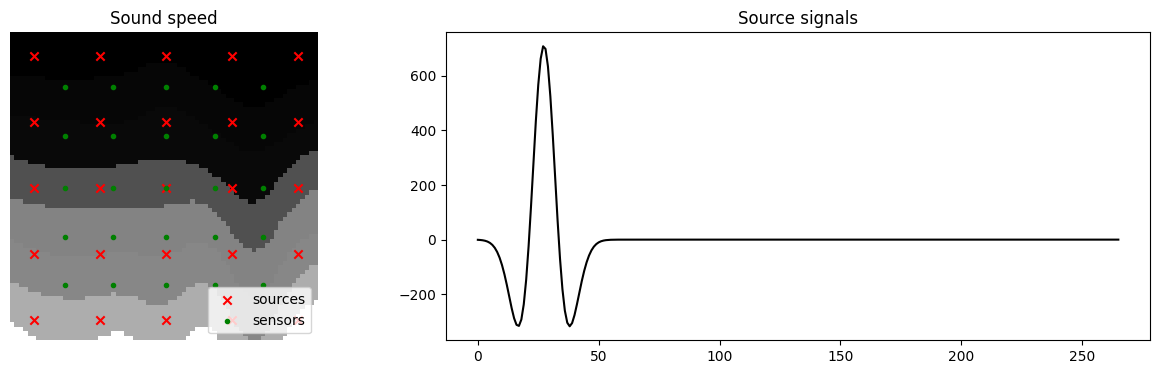

In [5]:
# Show comprehensive simulation setup

fig, ax = plt.subplots(1, 2, figsize=(15, 4), gridspec_kw={"width_ratios": [1, 2]})

ax[0].imshow(medium.sound_speed.on_grid, cmap="gray")
ax[0].scatter(
    source_positions[1], source_positions[0], c="r", marker="x", label="sources"
)
ax[0].scatter(
    sensors_positions[1], sensors_positions[0], c="g", marker=".", label="sensors"
)
ax[0].legend(loc="lower right")
ax[0].set_title("Sound speed")
ax[0].axis("off")

ax[1].plot(signal, label="Source 1", c="k")
ax[1].set_title("Source signals")
#ax[1].get_yaxis().set_visible(False)

## Test case A

In [6]:
jacobians = jnp.load("curvel_jac_model_{}_data_5_5_5.npy".format(model_index))

In [7]:
print(jacobians.shape[0])
# v stack dimensions 2 and 3
# jacobians_stack = jnp.vstack(jacobians[i])
jac_temp = []
print(jacobians[0].shape)
for i in range(jacobians.shape[0]):
    jac_temp.append(jnp.vstack(jacobians[i]))


jacobians_stack = jnp.vstack(jac_temp)

print(jacobians_stack.shape)

5
(25, 25, 9800)
(3125, 9800)


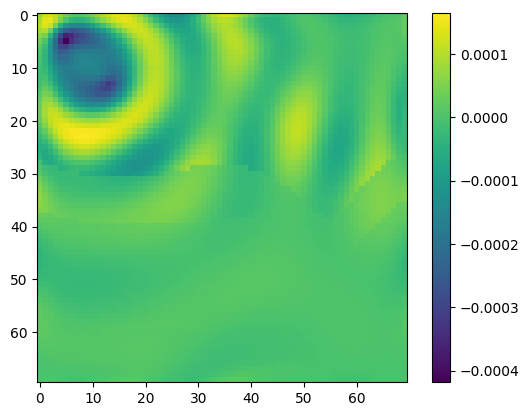

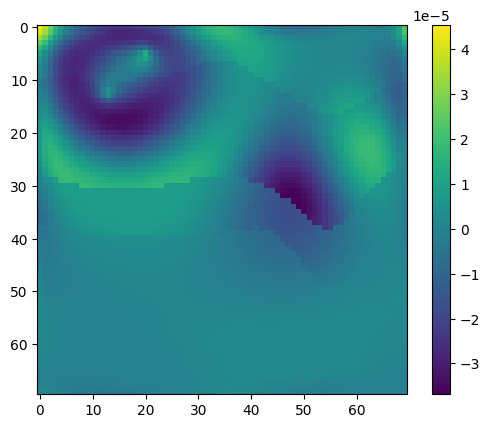

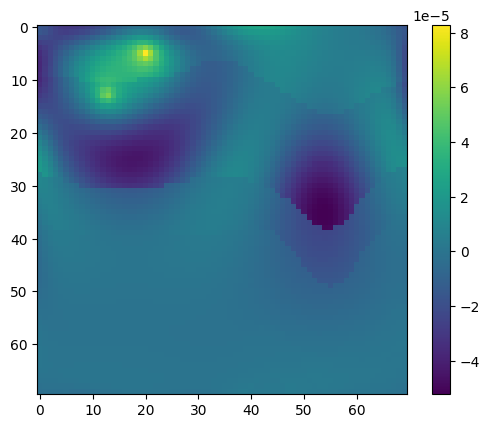

In [8]:
# jacobians
plt.imshow(jacobians[1,0,0,:].reshape(70,140)[:,:70])
plt.colorbar()
plt.show()

# real jacobians_stack
plt.imshow(jacobians_stack[25,:].reshape(70,140)[:,:70])
plt.colorbar()
plt.show()

# imaginary jacobians_stack
plt.imshow(jacobians_stack[25,:].reshape(70,140)[:,70:])
plt.colorbar()
plt.show()

In [9]:
complex_stack = []
for row in jacobians_stack:
    real_part = row.reshape(70,140)[:,:70]
    imaginary_part = row.reshape(70,140)[:,70:]
    complex_stack.append(real_part + 1j * imaginary_part)

# Convert to NumPy array if needed
complex_stack = jnp.array(complex_stack)

print(complex_stack.shape)

# Flatten all rows into num_rows x 4900 matrix
num_rows = jacobians_stack.shape[0]
complex_reshaped = np.empty((num_rows, 4900), dtype=np.complex128)

for i, complex_matrix in enumerate(complex_stack):
    complex_reshaped[i, :] = complex_matrix.flatten()

# Check the shape
print(complex_reshaped.shape)  # Should be (num_rows, 4900)

J_c = complex_reshaped


(3125, 70, 70)
(3125, 4900)


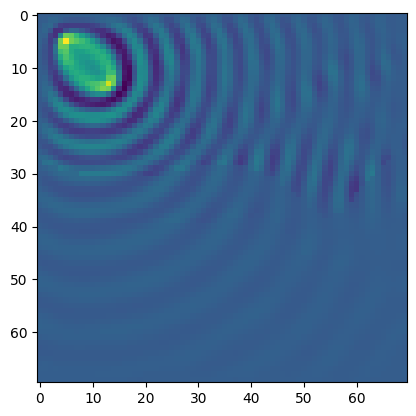

In [10]:
plt.imshow(np.imag(J_c[int(4*25*25),:].reshape(70,70)))

Iteration: 0, Sources Selected: 0j
Iteration: 1, Sources Selected: (125+0j)
Iteration: 2, Sources Selected: (250+0j)
Iteration: 3, Sources Selected: (375+0j)
Iteration: 4, Sources Selected: (500+0j)
Iteration: 5, Sources Selected: (625+0j)
Iteration: 6, Sources Selected: (750+0j)
Iteration: 7, Sources Selected: (875+0j)
Iteration: 8, Sources Selected: (1000+0j)
Iteration: 9, Sources Selected: (1125+0j)
Selected rows (indices): [ 750  751  752 ... 3122 3123 3124]
mask_history shape: (1250, 1250)


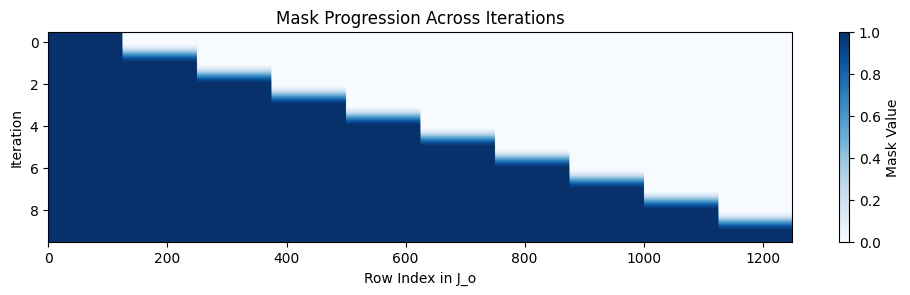

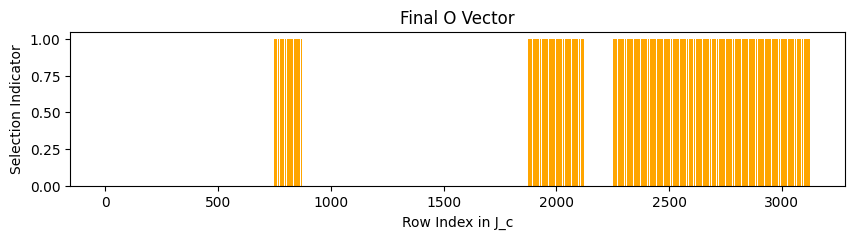

6 0
21 1
20 2
24 3
23 4
22 5
18 6
15 7
16 8
19 9
Ordered list [6, 21, 20, 24, 23, 22, 18, 15, 16, 19]


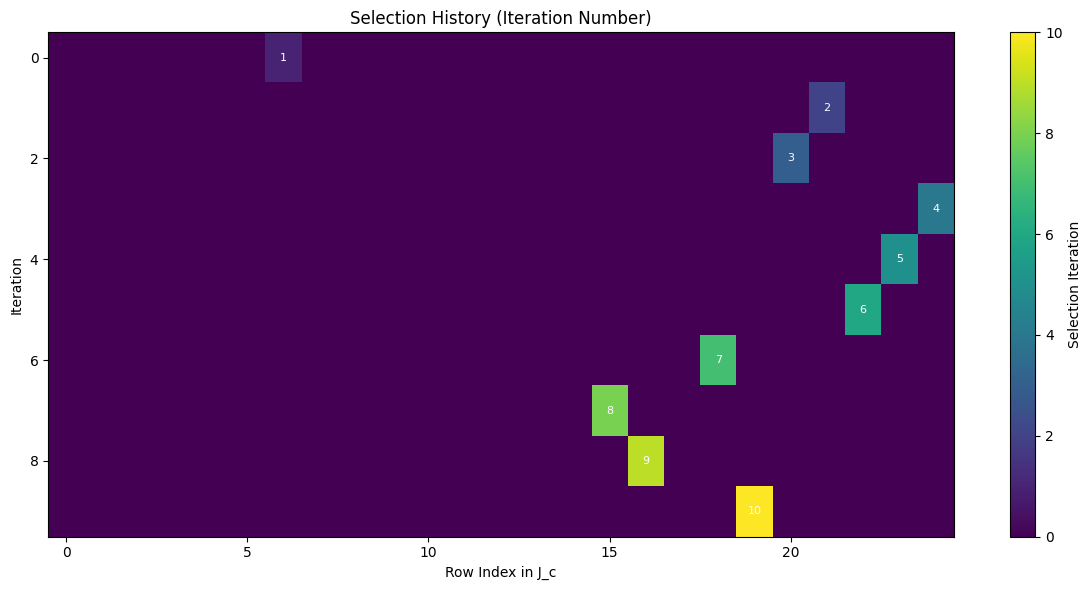

In [11]:
# loaded_data = jnp.load('arrays_complete_1GB.npz')

# # # Access arrays by index
# loaded_arrays = [loaded_data[f'arr_{i}'] for i in range(len(loaded_data))]

# vstack teh arrays
# J_c = (jnp.vstack(loaded_arrays))
# print(J_c.shape)


# Run the algorithm with logging
num_rows = 10
# threshold = 10e-10 # MODJO criterion
threshold = 1e-10

J_o_final, O_final, mask_history, criterion_log = iterative_selection_no_reselection(J_c, num_rows, n_freq=5, n_receivers=25,selection_mode="block", threshold=threshold)
# J_o_final, O_final, mask_history, criterion_log, augmented_J_o_history = iterative_selection_with_augmented_tracking(J_c, num_rows, threshold)

# Extract the selected row indices
selected_rows = jnp.where(O_final.flatten() == 1)[0]

# print("J_o shape", J_o_final.shape,"J_c shape", J_c.shape, "augmented_J_o_history shape", augmented_J_o_history.shape)  
# print("J_o shape", J_o_final.shape,"J_c shape", J_c.shape)

# Verify the results
# print("Expected significant rows (indices):", jnp.sort(expected_rows))
print("Selected rows (indices):", selected_rows)

# Check if all expected rows are in the selected rows
# all_expected_selected = jnp.all(jnp.isin(expected_rows, selected_rows))
# print("Are all expected rows among the selected rows?", all_expected_selected)

print('mask_history shape:', mask_history.shape)

# Plot the mask history
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.imshow(jnp.real(mask_history[:num_rows,:]), aspect='auto', cmap='Blues')
plt.colorbar(label="Mask Value")
plt.xlabel("Row Index in J_o")
plt.ylabel("Iteration")
plt.title("Mask Progression Across Iterations")

# Plot O_final
plt.figure(figsize=(10, 2))
plt.bar(jnp.arange(len(O_final)), jnp.real(O_final.flatten()), color='orange')
plt.xlabel("Row Index in J_c")
plt.ylabel("Selection Indicator")
plt.title("Final O Vector")
plt.show()

# # Plot the criterion values
# plt.subplot(2, 1, 2)
# plt.imshow(criterion_log, aspect='auto', cmap='viridis')
# plt.colorbar(label="Criterion Improvement")
# plt.xlabel("Row Index in J_c")
# plt.ylabel("Iteration")
# plt.title("Criterion Improvement Across Iterations")
# plt.tight_layout()
# plt.show()

# Plot the progression of active_J_o
# plt.figure(figsize=(12, 6))
# for i in range(active_J_o_history.shape[0]):
#     plt.subplot(num_rows // 2 + 1, 2, i + 1)
#     plt.imshow(active_J_o_history[i], aspect='auto', cmap='viridis')
#     plt.colorbar(label="Value")
#     plt.title(f"Iteration {i + 1}")
#     plt.xlabel("Features")
#     plt.ylabel("Rows in J_o")

# plt.tight_layout()
# plt.show()

# Plot the progression of augmented_J_o
# plt.figure(figsize=(12, 12))
# for i in range(augmented_J_o_history.shape[0]):
#     plt.subplot(num_rows // 2 + 1, 2, i + 1)
#     plt.imshow(jnp.real(augmented_J_o_history[i]), aspect='auto', cmap='viridis')
#     plt.colorbar(label="Value")
#     plt.title(f"Iteration {i + 1}")
#     # plt.xlabel("Features")
#     plt.ylabel("Rows in J_o")
# plt.suptitle("Progression of Augmented J_o Across Iterations")
# plt.tight_layout()
# plt.show()


# Create a matrix to record the selection history
selection_history = jnp.zeros_like(criterion_log, dtype=jnp.complex64)

# Populate the selection history matrix with iteration numbers
selected_rows = []
for iteration in range(criterion_log.shape[0]):
    best_row_idx = jnp.argmax(jnp.real(criterion_log[iteration]))  # Get the selected row for this iteration
    selected_rows.append(best_row_idx)
    selection_history = selection_history.at[iteration, best_row_idx].set(iteration + 1)

# Plot the selection history heatmap
plt.figure(figsize=(12, 6))

# Heatmap of selection history
plt.imshow(jnp.real(selection_history), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar(label="Selection Iteration")
plt.xlabel("Row Index in J_c")
plt.ylabel("Iteration")
plt.title("Selection History (Iteration Number)")

# Annotate the heatmap with iteration numbers
ordered_list = []
for iteration, row_idx in enumerate(selected_rows):
    plt.text(row_idx, iteration, str(iteration + 1), color="white", ha="center", va="center", fontsize=8)
    print(row_idx, iteration)
    ordered_list.append(row_idx.item())
print("Ordered list", ordered_list)
plt.tight_layout()
plt.show()


In [12]:
best_source_A = jnp.array(ordered_list)

In [13]:
best_source_A

Array([ 6, 21, 20, 24, 23, 22, 18, 15, 16, 19], dtype=int32)

## Test case C

In [17]:
jacobians = jnp.load("curvel_jac_model_{}_data_5_5_5.npy".format(model_index))
print(jacobians.shape)

transposed_jacobians = jnp.transpose(jacobians, axes=(1, 2, 0, 3))

print(transposed_jacobians.shape)

(5, 25, 25, 9800)
(25, 25, 5, 9800)


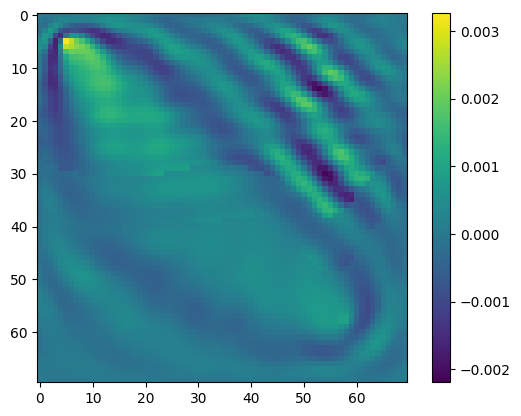

In [18]:
# plot the jacobians
plt.figure()
plt.imshow(jacobians[-1,0,-1,:].reshape(70,140)[:,:70], cmap='viridis')
plt.colorbar()
plt.show()

In [19]:
stacked_array = jnp.stack([array.reshape(-1, array.shape[-1]) for array in transposed_jacobians])
stacked_array.shape

(25, 125, 9800)

In [20]:
complex_stack_complete = []
for src in stacked_array:
    complex_stack = []
    for row in src:
        real_part = row.reshape(70,140)[:,:70]
        imaginary_part = row.reshape(70,140)[:,70:]
        complex_stack.append(real_part + 1j * imaginary_part)

    # Convert to NumPy array if needed
    complex_stack = jnp.array(complex_stack)

    # print(complex_stack.shape)

    # Flatten all rows into num_rows x 4900 matrix
    num_rows = complex_stack.shape[0]
    complex_reshaped = np.empty((num_rows, 4900), dtype=np.complex128)

    for i, complex_matrix in enumerate(complex_stack):
        complex_reshaped[i, :] = complex_matrix.flatten()
    
    complex_stack_complete.append(complex_reshaped)

complex_stack_complete = jnp.array(complex_stack_complete)
print(complex_stack_complete.shape)

complex_stack_complete_2D = jnp.vstack([array for array in complex_stack_complete])
print(complex_stack_complete_2D.shape)


(25, 125, 4900)
(3125, 4900)


In [23]:
params = {
    "criterion_threshold": 1e-10,
    "regularisation_loss": 0.0,
    "norm_loss": 0.03,
    "top_k_loss": 0.0,
    "differentiable_mask_sharpness": 10.0,
    "number_of_k":10,
    "hidden_size": 56,
    "num_hidden_layers": 3,
    "learning_rate": 1e-3,
    "num_iterations": 15,
    "print_gradients": False,
}

In [24]:
criterion_threshold = params["criterion_threshold"]

C_sources_1e_3 = [] 
for array in stacked_array:
    C_sources_1e_3.append(eigenvalue_criterion(array, threshold=criterion_threshold))

C_sources_1e_3 = jnp.array(C_sources_1e_3)

In [25]:
# Fully Connected Neural Network
class FullyConnectedNN(eqx.Module):
    layers: list
    activations: list

    def __init__(self, input_size, hidden_size, num_hidden_layers, key):
        keys = jax.random.split(key, num_hidden_layers + 1)
        self.layers = [eqx.nn.Linear(input_size, hidden_size, key=keys[0])] + \
                      [eqx.nn.Linear(hidden_size, hidden_size, key=k) for k in keys[1:-1]] + \
                      [eqx.nn.Linear(hidden_size, input_size, key=keys[-1])]
        
        self.activations = [jax.nn.tanh] * num_hidden_layers + [jax.nn.sigmoid]

    def __call__(self, x):
        for layer, activation in zip(self.layers, self.activations):
            x = activation(layer(x))
        return x

# Differentiable Mask
def differentiable_mask(probabilities, sharpness=10.0):
    return jax.nn.sigmoid(sharpness * (probabilities - 0.5))

def top_k_regularization(soft_mask, k=10):
    top_k_values = jax.lax.top_k(soft_mask, k)[0]
    penalty = jnp.sum(soft_mask) - jnp.sum(top_k_values)
    return penalty

# Differentiable Loss Function
def differentiable_loss_fn(model, x, matrix, criterion_threshold ,sharpness=10.0, mask_penalty=0.1):
    probabilities = model(x)  # Predict probabilities
    soft_mask = differentiable_mask(probabilities, sharpness)  # Generate soft mask
    
    

    multiplier = matrix.shape[0] // soft_mask.shape[0]
    soft_mask = jnp.repeat(soft_mask, multiplier, axis=0)

    weighted_matrix = soft_mask[:, None] * matrix  # Apply mask to matrix rows

    regularization_loss = mask_penalty * jnp.mean(soft_mask * (1 - soft_mask))  # Encourage binary mask
    norm_loss = jnp.linalg.norm(soft_mask, ord=1)
    top_k_loss = top_k_regularization(soft_mask, k=params["number_of_k"])

    singular_loss = eigenvalue_criterion(weighted_matrix, threshold=criterion_threshold)

    return -(singular_loss) + params["regularisation_loss"]*regularization_loss + params["norm_loss"]*norm_loss + params["top_k_loss"]*top_k_loss



In [26]:
# Example Usage
key = jax.random.PRNGKey(42)
input_size = C_sources_1e_3.shape[0]
hidden_size = params["hidden_size"]
num_hidden_layers = params["num_hidden_layers"]
model = FullyConnectedNN(input_size, hidden_size, num_hidden_layers, key)

print("Model:", model)

# matrix = jax.random.normal(key, (100, 50))  # Matrix with 100 rows and 50 columns
matrix = complex_stack_complete_2D
# x = jax.random.normal(key, (input_size,))  # Input to the network
x = C_sources_1e_3
# x = (x - jnp.mean(x)) / jnp.std(x)
x = (x - jnp.min(x)) / (jnp.max(x) - jnp.min(x))

Model: FullyConnectedNN(
  layers=[
    Linear(
      weight=f32[56,25],
      bias=f32[56],
      in_features=25,
      out_features=56,
      use_bias=True
    ),
    Linear(
      weight=f32[56,56],
      bias=f32[56],
      in_features=56,
      out_features=56,
      use_bias=True
    ),
    Linear(
      weight=f32[56,56],
      bias=f32[56],
      in_features=56,
      out_features=56,
      use_bias=True
    ),
    Linear(
      weight=f32[25,56],
      bias=f32[25],
      in_features=56,
      out_features=25,
      use_bias=True
    )
  ],
  activations=[
    <wrapped function tanh>,
    <wrapped function tanh>,
    <wrapped function tanh>,
    <wrapped function sigmoid>
  ]
)


Step 0, Loss: -1622.071044921875
Step 1, Loss: -1623.7574462890625
Step 2, Loss: -1625.255615234375
Step 3, Loss: -1626.626708984375
Step 4, Loss: -1627.921142578125
Step 5, Loss: -1629.174560546875
Step 6, Loss: -1630.4041748046875
Step 7, Loss: -1631.6143798828125
Step 8, Loss: -1632.800048828125
Step 9, Loss: -1633.9508056640625
Step 10, Loss: -1635.0513916015625
Step 11, Loss: -1636.086669921875
Step 12, Loss: -1637.0423583984375
Step 13, Loss: -1637.9073486328125
Step 14, Loss: -1638.6741943359375


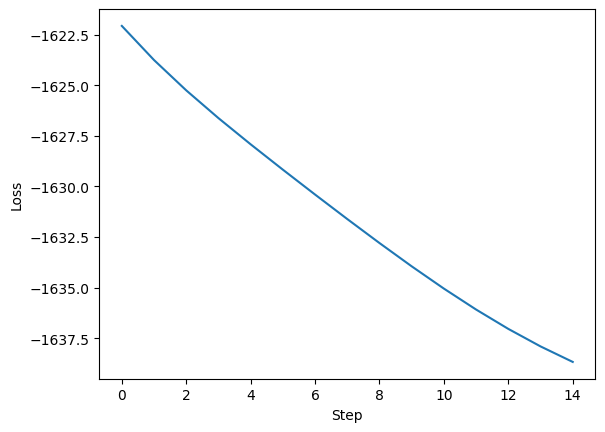

In [29]:
def train_step(model, matrix, criterion_threshold, optimizer, opt_state, x, logs):
    # Compute loss and gradients
    loss_and_grad_fn = eqx.filter_value_and_grad(differentiable_loss_fn)
    loss, grads = loss_and_grad_fn(model, x, matrix, criterion_threshold=criterion_threshold, sharpness=params["differentiable_mask_sharpness"], mask_penalty=1.0)
    
    if params["print_gradients"]:  
        jax.tree_util.tree_map(lambda g: print("Gradient shape:", g.shape, "Gradient values:", g), grads)
        jax.tree_util.tree_map(lambda g: print(f"Gradient shape: {g.shape}, Min: {jnp.min(g)}, Max: {jnp.max(g)}, Mean: {jnp.mean(g)}"), grads)

    # Update optimizer state and model
    updates, opt_state = optimizer.update(grads, opt_state, eqx.filter(model, eqx.is_inexact_array))
    model = eqx.apply_updates(model, updates)

    # Log the network output (predicted probabilities)
    probabilities = model(x)  # Network output
    logs["probabilities"].append(probabilities)

    # Log the mask M
    soft_mask = differentiable_mask(probabilities, sharpness=params["differentiable_mask_sharpness"])  # Differentiable mask
    logs["masks"].append(soft_mask)

    return loss, model, opt_state


# Initialize the model and optimizer
key = jax.random.PRNGKey(42)
model = FullyConnectedNN(input_size, hidden_size, num_hidden_layers, key)
optimizer = optax.adamw(params["learning_rate"])  # Adam optimizer
opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))  # Initialize optimizer state
initial_predictions = model(x)  # Initial predictions

# Training loop
num_steps = params["num_iterations"]
losses = []
logs = {"probabilities": [], "masks": []}
for step in range(num_steps):
    loss, model, opt_state = train_step(model, matrix, criterion_threshold, optimizer, opt_state, x, logs)
    losses.append(loss)

    if step % 1 == 0:
        print(f"Step {step}, Loss: {loss}")

# Plot the losses
plt.figure()
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()


Step 0: Probabilities: [0.558813   0.52045476 0.48323712 0.5318182  0.50497717 0.5159666
 0.4900296  0.4925129  0.5085864  0.5203947  0.4959487  0.4936669
 0.5100957  0.5771542  0.55112875 0.4898637  0.5070176  0.48427457
 0.50223136 0.5115504  0.47933462 0.47837335 0.5309584  0.5062305
 0.47593838]
Step 0: Mask: [0.64293593 0.55095935 0.45819068 0.57888114 0.5124403  0.53983194
 0.47509468 0.48129103 0.52145284 0.5508107  0.4898731  0.4841725
 0.5252179  0.6838544  0.62510824 0.47468087 0.5175368  0.46076727
 0.50557816 0.528844   0.44851962 0.44614312 0.5767837  0.5155711
 0.44013453]
Step 1: Probabilities: [0.5588622  0.5270212  0.49061158 0.54163677 0.51194054 0.5228729
 0.49411288 0.49960488 0.5160019  0.5303377  0.5049064  0.5012632
 0.50990784 0.5811646  0.55429906 0.49551272 0.51465607 0.49366102
 0.5129051  0.5194196  0.49008337 0.480646   0.5412061  0.5096515
 0.48565027]
Step 1: Mask: [0.64304894 0.56714505 0.4765462  0.6026137  0.529816   0.5569343
 0.48528644 0.49901217 0.

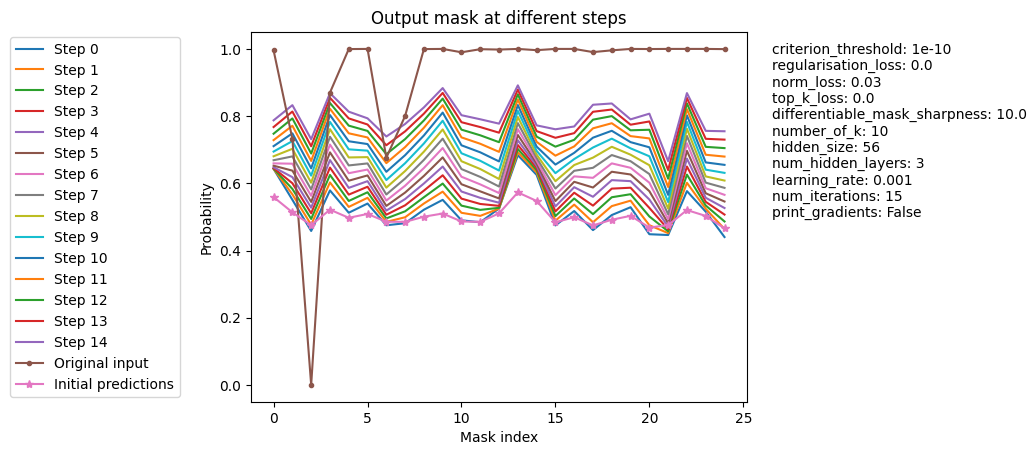

In [30]:
# Print the first few steps for inspection
for i, (probs, mask) in enumerate(zip(logs["probabilities"], logs["masks"])):
    print(f"Step {i}: Probabilities: {probs}")
    print(f"Step {i}: Mask: {mask}")
    if i > 5:  # Limit to first few steps for readability
        break

# Example: Plot the first mask at different training steps
steps_to_plot = [i for i in range(num_steps)]  # Select steps to visualize
plt.figure()

for step in steps_to_plot:
    plt.title(f"Output mask at different steps")
    plt.plot(logs["masks"][step], label=f"Step {step}")
    # plt.colorbar(label="Mask Values")
    plt.xlabel("Mask index")
    plt.ylabel("Probability")

plt.plot(x, ".-", label="Original input")
plt.plot(initial_predictions,"*-", label="Initial predictions")
# put the legend outside of the graph, to the left
plt.legend(loc='center left', bbox_to_anchor=(-0.5, 0.5))

# add the params dictionary to the plot, on the right, one key per line
plt.text(1.05, 0.5, '\n'.join([f"{key}: {value}" for key, value in params.items()]), transform=plt.gca().transAxes)

plt.show()

In [31]:
final_mask = logs["masks"][-1]
best_sources_C = jnp.argsort(final_mask)[-10:]
print("best source index", best_sources_C)

best source index [20  4  8  1 17 18  3 22  9 13]


## Final loss calculation


In [15]:
def process_matrix_with_mask(matrix, best_source_index, final_mask, eigenvalue_criterion, threshold):
    """
    Apply a mask to the matrix based on the best source index and compute the singular loss.

    Args:
        matrix (jnp.ndarray): Input matrix to be processed.
        best_source_index (int): Index of the best source.
        final_mask (jnp.ndarray): Initial mask array.
        eigenvalue_criterion (callable): Function to compute the eigenvalue-based loss.
        threshold (float): Threshold for the eigenvalue criterion.

    Returns:
        float: Singular loss computed for the masked matrix.
        jnp.ndarray: Final mask applied to the matrix.
    """
    print("Best source index:", best_source_index)

    # Create a mask with the best sources
    mask_best_source = jnp.zeros_like(final_mask)
    mask_best_source = mask_best_source.at[best_source_index].set(1.0)
    print(mask_best_source, "sum:", jnp.sum(mask_best_source))

    # Repeat the mask to match the matrix dimensions
    multiplier = matrix.shape[0] // mask_best_source.shape[0]
    full_mask = jnp.repeat(mask_best_source, multiplier, axis=0)

    # Apply the mask to the matrix
    weighted_matrix = full_mask[:, None] * matrix

    # Compute the singular loss
    singular_loss = eigenvalue_criterion(weighted_matrix, threshold=threshold)
    eigenvalues = jnp.sort(jnp.linalg.svdvals(weighted_matrix)**2)[::-1]

    print("Singular loss:", singular_loss)

    return singular_loss, full_mask, eigenvalues

In [34]:
final_loss_A, final_mask_A, eigenvlues_A = process_matrix_with_mask(matrix, best_source_A, jnp.zeros(num_sources) , eigenvalue_criterion, threshold=criterion_threshold)

# best_source_A = jnp.array([21 ,20, 22, 23, 24, 16, 15, 17, 18, 19])

Best source index: [ 6 21 20 24 23 22 18 15 16 19]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1.] sum: 10.0
Singular loss: 1367.8789


In [35]:
final_loss_C, final_mask_C, eigenvlues_C = process_matrix_with_mask(matrix, best_sources_C, logs["masks"][-1], eigenvalue_criterion, threshold=criterion_threshold)

Best source index: [20  4  8  1 17 18  3 22  9 13]
[0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0.
 0.] sum: 10.0
Singular loss: 1380.2522


In [36]:
best_sources_D = jnp.array([11 , 5, 15,  0, 17,  9,  8,  4, 12, 13])
final_loss_D, final_mask_D, eigenvlues_D = process_matrix_with_mask(matrix, best_sources_D, logs["masks"][-1], eigenvalue_criterion, threshold=criterion_threshold)

Best source index: [11  5 15  0 17  9  8  4 12 13]
[1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.
 0.] sum: 10.0
Singular loss: 1380.3777


In [37]:
final_loss_comprehensive = eigenvalue_criterion(matrix, threshold=params["criterion_threshold"])
eigenvlues_comprehensive = jnp.sort(jnp.linalg.svdvals(matrix)**2)[::-1]
print("Comprehensive loss:", final_loss_comprehensive)

Comprehensive loss: 1736.6992


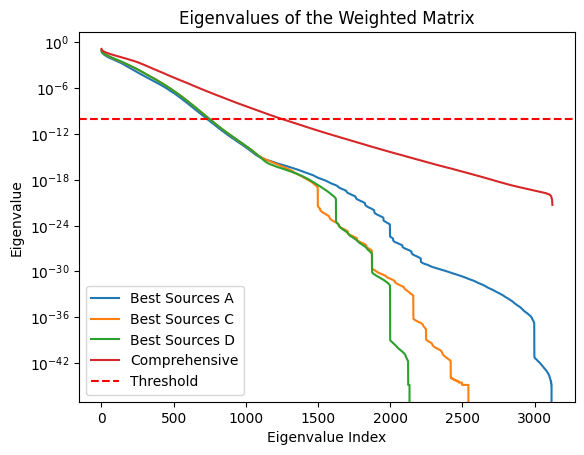

In [38]:
# plot all the eigenvalues
plt.figure()
plt.semilogy(eigenvlues_A, label="Best Sources A")
plt.semilogy(eigenvlues_C, label="Best Sources C")
plt.semilogy(eigenvlues_D, label="Best Sources D")
plt.semilogy(eigenvlues_comprehensive, label="Comprehensive")
plt.axhline(y=criterion_threshold, color='r', linestyle='--', label="Threshold")
# plt.xlim(0, 100)
# plt.ylim(1e-4, 1e-1)
plt.legend()
plt.xlabel("Eigenvalue Index")
plt.ylabel("Eigenvalue")
plt.title("Eigenvalues of the Weighted Matrix")
plt.show()


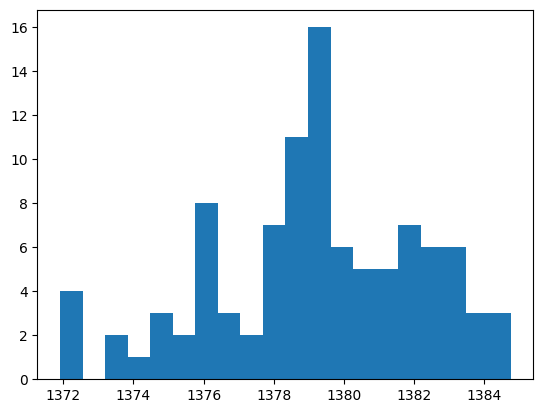

Mean loss: 1379.1927
Std loss: 2.9678857
Min loss: 1371.9104
Max loss: 1384.7566
Median loss: 1379.25


In [30]:
# random selection of sources

number_of_random_realisations = 100
loss_random = []

for i in range(number_of_random_realisations):
    best_source_A = jnp.array(np.random.choice(jnp.arange(0, 25), 10, replace=False))

    mask_best_source_A = jnp.zeros_like(final_mask)
    mask_best_source_A = mask_best_source_A.at[best_source_A].set(1.0)
    if jnp.sum(mask_best_source_A) != 10:
        print("Error in mask")
        break

    multiplier = matrix.shape[0] // mask_best_source_A.shape[0]
    full_mask = jnp.repeat(mask_best_source_A, multiplier, axis=0)

    weighted_matrix = full_mask[:, None] * matrix  # Apply mask to matrix rows
    # print("Weighted matrix shape:", weighted_matrix.shape)

    singular_loss = eigenvalue_criterion(weighted_matrix, threshold=params["criterion_threshold"])
    loss_random.append(singular_loss)


loss_random = jnp.array(loss_random)

plt.figure()
plt.hist(loss_random, bins=20)
plt.show()


print("Mean loss:", jnp.mean(loss_random))
print("Std loss:", jnp.std(loss_random))
print("Min loss:", jnp.min(loss_random))
print("Max loss:", jnp.max(loss_random))
print("Median loss:", jnp.median(loss_random))

## Inversion

In [83]:

# Case B
test_case_B = False

if test_case_B:
    source_trajectories = jnp.load('source_trajectories.npy')
    source_positions = (source_trajectories[-1][:,0], source_trajectories[-1][:,1])
    # transform every values in source_positions to integers
    source_positions = (source_positions[0].astype(int), source_positions[1].astype(int))
    # add 10 more sources to the source positions to reach 20 sources
    # source_positions = (jnp.hstack([source_positions[0], jnp.repeat(0,10)]), jnp.hstack([source_positions[1], jnp.repeat(0,10)]))

    

else:
    filtered_x = source_positions[0][best_sources_C]
    filtered_y = source_positions[1][best_sources_C]

    source_positions = (filtered_x, filtered_y)

source_positions

(Array([65,  5, 20,  5, 50, 50,  5, 65, 20, 35], dtype=int32),
 Array([ 5, 65, 50, 20, 35, 50, 50, 35, 65, 50], dtype=int32))

In [96]:
src_signal = jnp.stack([signal])

# We can compile the entire function! All the constructors
# that don't depend on the inputs will be statically compiled
# and run only once.
@jit
def single_source_simulation(sound_speed, source_num):

        

    # if isinstance(source_num, int):
    x = lax.dynamic_slice(source_positions[0], (source_num,), (1,))
    y = lax.dynamic_slice(source_positions[1], (source_num,), (1,))
        # print("x, y","int", x,y)

    # else:
    #     x = [source_num[0].astype(jnp.int32)]
    #     y = [source_num[1].astype(jnp.int32)]
    #     print("x, y","array", x,y)
        
    sources = Sources((x, y), src_signal, dt=time_axis.dt, domain=domain)

    # Updating medium with the input speed of sound map
    medium = Medium(domain=domain, sound_speed=sound_speed, pml_size=10)

    # Run simulations
    rf_signals = simulate_wave_propagation(
        medium, time_axis, sources=sources, sensors=sensors, checkpoint=True
    )
    return rf_signals[..., 0]

<class 'int'>


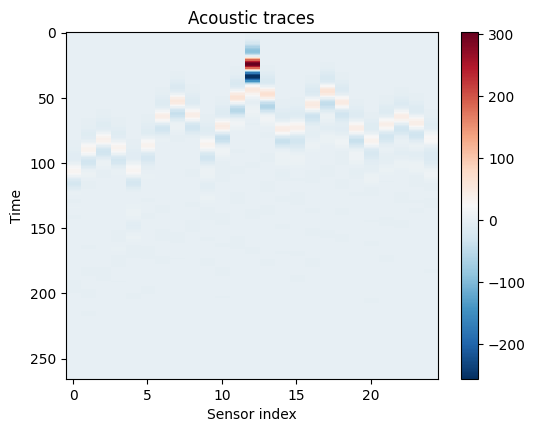

In [97]:
print(type(num_sources//2))
# print(len(source_trajectories[-1][0]))
p = single_source_simulation(medium.sound_speed, num_sources // 2)
# p = single_source_simulation(medium.sound_speed, source_trajectories[-1][0])
# 
# Visualize the acoustic traces
plt.figure(figsize=(6, 4.5))
maxval = jnp.amax(jnp.abs(p))
plt.imshow(
    p, cmap="RdBu_r", interpolation="nearest", aspect="auto"
)
plt.colorbar()
plt.title("Acoustic traces")
plt.xlabel("Sensor index")
plt.ylabel("Time")
plt.show()

In [98]:

# mask = circ_mask(domain.N, 80, (128, 128))
# mask = FourierSeries(jnp.expand_dims(mask, -1), domain)

# mask the pixel of the source and receviers defined above
mask = jnp.ones(domain.N)

mask = mask.at[sensors_positions[0], sensors_positions[1]].set(0.0)




def get_sound_speed(params):
    return params + compose(params)(nn.sigmoid) * mask

# initial model is the blurred model
params = blurred_model
# params = homogenous_model
# params = medium.sound_speed * 0.1 + 
params

array([[2145.4688, 2145.457 , 2145.4338, ..., 2123.0535, 2123.0046,
        2122.9802],
       [2146.3662, 2146.3545, 2146.331 , ..., 2123.8633, 2123.8142,
        2123.7898],
       [2148.1611, 2148.1494, 2148.1257, ..., 2125.4827, 2125.4336,
        2125.4092],
       ...,
       [3164.4155, 3164.3599, 3164.2485, ..., 3144.3838, 3144.4834,
        3144.534 ],
       [3166.6047, 3166.549 , 3166.4377, ..., 3146.8064, 3146.9072,
        3146.958 ],
       [3167.7004, 3167.6448, 3167.5334, ..., 3148.0193, 3148.1208,
        3148.1719]], dtype=float32)

In [99]:
from jwave.signal_processing import analytic_signal
from jaxdf.operators import gradient, functional

def hilbert_transf(signal, noise=0.2):
    x = jnp.abs(analytic_signal(signal))
    return x

def loss_func(params, source_num):
    c0 = get_sound_speed(params)
    p = single_source_simulation(c0, source_num)
    data = p_data[source_num]
    # return jnp.mean(jnp.abs(hilbert_transf(p) -hilbert_transf(data)) ** 2)
    # L2 loss
    return jnp.mean((p - data) ** 2)

loss_with_grad = value_and_grad(loss_func, argnums=0)

def loss_func_multi(params, source_nums):
    """
    Compute the loss for multiple sources by averaging their individual losses.
    """
    c0 = get_sound_speed(params)
    total_loss = 0.0
    for src_num in source_nums:
        p = single_source_simulation(c0, src_num)
        data = p_data[src_num]
        total_loss += jnp.mean((p - data) ** 2)  # L2 loss
    return total_loss / len(source_nums)  # Average loss over sources

# loss_with_grad_multi = value_and_grad(loss_func_multi, argnums=0)

In [100]:
batch_simulations = vmap(single_source_simulation, in_axes=(None, 0))
p_data = batch_simulations(medium.sound_speed, jnp.arange(num_sources))
print(f"Size of data [Source idx, Time, Sensor idx]: {p_data.shape}")

Size of data [Source idx, Time, Sensor idx]: (25, 266, 25)


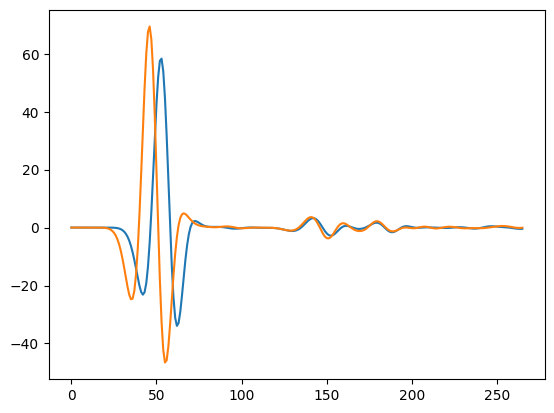

In [101]:
plt.plot(p_data[0, :, 0])
plt.plot(p_data[1, :, 1])
plt.show()

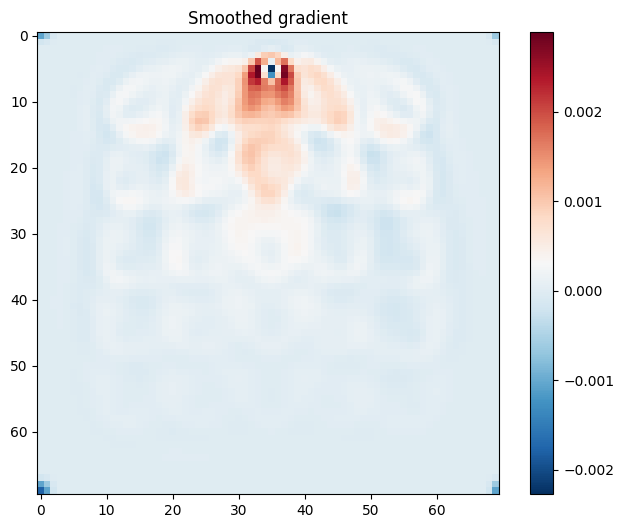

In [102]:
from jaxdf.operators import compose

def smooth_fun(gradient):
    # x = gradient.on_grid[..., 0]
    x = gradient
    for _ in range(1):
        x = smooth(x)
    return x

loss, gradient = loss_with_grad(params, source_num=2)
gradient = smooth_fun(gradient)

# Viualize
plt.figure(figsize=(8, 6))
plt.imshow(gradient, cmap="RdBu_r")
plt.title("Smoothed gradient")
plt.colorbar()
plt.show()

In [103]:
losshistory = []
reconstructions = []
num_steps = 250

# Define optimizer
init_fun, update_fun, get_params = optimizers.adam(20.0, 0.9, 0.9)
opt_state = init_fun(params)

# Define and compile the update function
@jit
def update(opt_state, key, k):
    v = get_params(opt_state)
    src_num = random.choice(key, num_sources)
    lossval, gradient = loss_with_grad(v, src_num)
    gradient = smooth_fun(gradient)
    return lossval, update_fun(k, gradient, opt_state)

# @jit
# def update_multi(opt_state, key, k, batch_size):
#     """
#     Perform a single optimization step using multiple sources.
#     """
#     v = get_params(opt_state)
#     src_nums = random.choice(key, num_sources, shape=(batch_size,), replace=False)
#     lossval, gradient = loss_with_grad_multi(v, src_nums)
#     # gradient = smooth_fun(gradient)  # Optional smoothing
#     return lossval, update_fun(k, gradient, opt_state)

# @jit
# def update_multi(opt_state, key, k):
#     """
#     Perform a single optimization step using multiple sources.
#     """
#     v = get_params(opt_state)
    
#     # Randomly select multiple source indices
#     src_nums = random.choice(key, num_sources, shape=(batch_size,), replace=False)
    
#     # Compute the loss and gradient for all selected sources
#     def compute_loss_for_source(src_num):
#         c0 = get_sound_speed(v)
#         p = single_source_simulation(c0, src_num)
#         data = p_data[src_num]
#         return jnp.mean((p - data) ** 2)
    
#     # Vectorized computation over all selected sources
#     loss_vals = jax.vmap(compute_loss_for_source)(src_nums)
#     total_loss = jnp.mean(loss_vals)  # Average the losses across sources
    
#     # Compute the gradient of the averaged loss
#     total_loss_grad = jax.grad(lambda v: jnp.mean(jax.vmap(compute_loss_for_source)(src_nums)))(v)
    
#     # Update the parameters
#     return total_loss, update_fun(k, total_loss_grad, opt_state)


@jit
def update_multi(opt_state, key, k):
    """
    Perform a single optimization step using gradients from multiple sources summed together.
    """
    v = get_params(opt_state)
    
    # Randomly select multiple source indices
    src_nums = random.choice(key, num_sources, shape=(batch_size,), replace=False)
    
    # Compute the gradient for each source
    def compute_gradient_for_source(src_num):
        def loss_for_source(params):
            c0 = get_sound_speed(params)
            p = single_source_simulation(c0, src_num)
            data = p_data[src_num]
            return jnp.mean((p - data) ** 2)
        
        return jax.grad(loss_for_source)(v)
    
    # Vectorized gradient computation over all sources
    gradients = jax.vmap(compute_gradient_for_source)(src_nums)
    
    # Sum gradients from all sources
    total_gradient = jnp.sum(gradients, axis=0)
    
    # Compute the loss for logging purposes
    def compute_loss_for_source(src_num):
        c0 = get_sound_speed(v)
        p = single_source_simulation(c0, src_num)
        data = p_data[src_num]
        return jnp.mean((p - data) ** 2)
    
    loss_vals = jax.vmap(compute_loss_for_source)(src_nums)
    total_loss = jnp.sum(loss_vals)  # Sum of the losses across sources
    
    # Update the parameters
    return total_loss, update_fun(k, total_gradient, opt_state)

@partial(pmap, axis_name="devices")
def compute_gradients(params, src_num):
    """
    Compute the gradient for a single source, parallelized across devices.
    """
    def loss_for_source(params):
        c0 = get_sound_speed(params)
        p = single_source_simulation(c0, src_num)
        data = p_data[src_num]
        return jnp.mean((p - data) ** 2)

    # Compute gradient
    gradient = jax.grad(loss_for_source)(params)

    # Aggregate gradients across devices
    total_gradient = jax.lax.pmean(gradient, axis_name="devices")
    return total_gradient


def update_multi_pmap(opt_state, key, k):
    """
    Perform a single optimization step using gradients from multiple sources,
    computed in parallel across devices.
    """
    # Extract parameters as a concrete DeviceArray
    v = jax.device_get(get_params(opt_state))  # Ensure `v` is concrete

    # Split the random key for each device
    keys = random.split(key, len(jax.devices()))

    # Predefine source indices for all devices
    src_nums = jnp.arange(len(jax.devices())) % num_sources  # Cycle through sources

    # Broadcast parameters to all devices
    params_broadcast = jax.device_put_replicated(v, jax.devices())

    # Compute gradients in parallel using `pmap`
    gradients = compute_gradients(params_broadcast, src_nums)

    # Compute the loss for logging purposes
    def compute_loss_for_source(params, src_num):
        c0 = get_sound_speed(params)
        p = single_source_simulation(c0, src_num)
        data = p_data[src_num]
        return jnp.mean((p - data) ** 2)

    losses = jax.vmap(compute_loss_for_source, in_axes=(None, 0))(v, src_nums)
    total_loss = jnp.sum(losses)  # Sum of the losses across sources

    # Update the parameters using the gradient from the first device
    return total_loss, update_fun(k, gradients[0], opt_state)



# Main loop
pbar = tqdm(range(num_steps))
_, key = random.split(key)
batch_size = 10
num_devices = 12
params = blurred_model

for k in pbar:
    _, key = random.split(key)

    lossval, opt_state = update(opt_state, key, k)

    # Perform update using multiple sources
    # lossval, opt_state = update_multi(opt_state, key, k)

    # Perform update using multiple sources in parallel
    # lossval, opt_state = update_multi_pmap(opt_state, key, k)
    

    ## For logging
    new_params = get_params(opt_state)
    reconstructions.append(get_sound_speed(new_params))
    losshistory.append(lossval)
    pbar.set_description("Loss: {}".format(lossval))


  0%|          | 0/250 [00:00<?, ?it/s]

Loss: 0.6996229887008667: 100%|██████████| 250/250 [00:14<00:00, 16.94it/s] 


In [104]:
source_positions

(Array([ 5,  5,  5,  5,  5, 20, 20, 20, 20, 20, 35, 35, 35, 35, 35, 50, 50,
        50, 50, 50, 65, 65, 65, 65, 65], dtype=int32),
 Array([ 5, 20, 35, 50, 65,  5, 20, 35, 50, 65,  5, 20, 35, 50, 65,  5, 20,
        35, 50, 65,  5, 20, 35, 50, 65], dtype=int32))

In [105]:
# L1 norm model loss
loss_l1 = jnp.linalg.norm(reconstructions[-1] - true_model, ord=1)
print("L1 norm loss:", loss_l1)

L1 norm loss: 21537.11


/tmp/ipykernel_2735349/1996503626.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


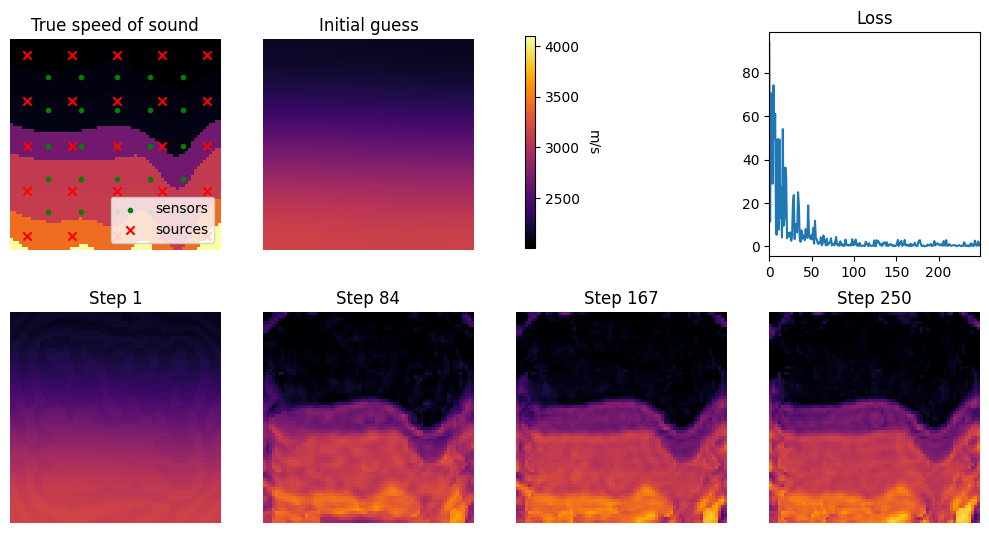

In [107]:
sos_original = get_sound_speed(params)
true_sos = true_model
vmin = np.amin(true_sos)
vmax = np.amax(true_sos)

fig, axes = plt.subplots(2, 4, figsize=(10, 5.5))

k = 0

recs = jnp.linspace(0, num_steps - 1, 4).astype(jnp.int32)

for row in range(2):
    for col in range(4):
        if k == 0:
            axes[row, col].imshow(true_sos, cmap="inferno", vmin=vmin, vmax=vmax)
            axes[row, col].scatter(
                sensors_positions[1],
                sensors_positions[0],
                c="g",
                marker=".",
                label="sensors",
            )
            axes[row, col].scatter(
                source_positions[1],
                source_positions[0],
                c="r",
                marker="x",
                label="sources",
            )
            axes[row, col].legend(loc="lower right")
            axes[row, col].set_title("True speed of sound")
            axes[row, col].set_axis_off()
        elif k == 1:
            im_original = axes[row, col].imshow(sos_original, cmap="inferno", vmin=vmin, vmax=vmax)
            axes[row, col].set_axis_off()
            axes[row, col].set_title("Initial guess")
            
            cbar_ax = fig.add_axes([0.53, 0.54, 0.01, 0.385])
            cbar = plt.colorbar(im_original, cax=cbar_ax)
            cbar.ax.get_yaxis().labelpad = 15
            cbar.ax.set_ylabel('m/s', rotation=270)
        elif k == 2:
            axes[row, col].set_axis_off()
        elif k == 3:
            axes[row, col].plot(losshistory)
            axes[row, col].set_title("Loss")
            #axes[row, col].set_xticks([], [])
            axes[row, col].margins(x=0)
        else:
            axes[row, col].imshow(reconstructions[recs[k - 4]], cmap="inferno", vmin=vmin, vmax=vmax)
            axes[row, col].set_axis_off()
            axes[row, col].set_title("Step {}".format(recs[k - 4] + 1))
        k += 1

# Scale bar
# from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
# import matplotlib.font_manager as fm
# fontprops = fm.FontProperties(size=12)
# scalebar = AnchoredSizeBar(
#     axes[-1, -1].transData,
#     100, '1 cm', 'lower right', 
#     pad=0.3,
#     color='white',
#     frameon=False,
#     size_vertical=2,
#     fontproperties=fontprops)
# axes[-1, -1].add_artist(scalebar)
        
fig.tight_layout()
plt.show()

# plt.savefig('fwi.pdf')